### Data Preparation

Data preparation: Now keeps only tail data and normalizes HiggsM values for conditioning.

Model: ConditionalMLP now accepts multiple inputs based on the number of features:

The HiggsM conditioning information is projected and added to the network, allowing the model to learn how the velocity field varies with HiggsM.

Training: Now passes the corresponding HiggsM value for each sample during training.

Sampling (cell 12): Samples across the entire HiggsM range including the pole region. The model uses learned patterns from tail data to extrapolate predictions into the pole region where it has no direct training data.

In [2]:
import tqdm
import math
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Set device - use CUDA if available, otherwise CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

raw_df = pd.read_hdf('data_files/new_Input_NonResonant_yy_25th_January2026.h5', key='VBF_Polarisation_Tree')

# Define bounds and number of bins
lower_bound = 115000
upper_bound = 135000
num_bins = 1100

# Creating frequency distribution for HiggsM
freq = pd.cut(raw_df['HiggsM'], bins=num_bins)
freq_counts = freq.value_counts().sort_index()
higgsM_values = [interval.mid for interval in freq_counts.index]
frequencies = freq_counts.values.tolist()

# Create DataFrame for ML Model
# Applying the bounds to HiggsM values
model_df = pd.DataFrame({'HiggsM': higgsM_values, 'Frequency': frequencies})
mask1 = model_df['HiggsM'] > upper_bound
mask2 = model_df['HiggsM'] < lower_bound
model_df_tails = model_df[mask1 | mask2]

# Applying the same bounds to the raw data for the other features
grouped_df = raw_df.groupby(pd.cut(raw_df['HiggsM'], bins=num_bins), observed=True).mean(numeric_only=True)
grouped_df.index.name = 'HiggsM_interval'
grouped_df = grouped_df.reset_index()
grouped_df['HiggsM_interval'] = grouped_df['HiggsM_interval'].apply(lambda x: x.mid).astype(float)
mask3 = grouped_df['HiggsM_interval'] > upper_bound
mask4 = grouped_df['HiggsM_interval'] < lower_bound
others_df_tails = grouped_df[mask3 | mask4]

# Combine tail data for other features and HiggsM frequency into a single DataFrame for training
model_df_tails.index.name = others_df_tails.index.name
combined_tails_df = pd.concat([model_df_tails, others_df_tails.drop(columns=['HiggsM', 'HiggsM_interval'])], axis=1)

# Save the combined tails DataFrame to a CSV file for inspection
# Filter out unnecessary columns and save the relevant features along with HiggsM and Frequency
combined_tails_df.to_csv('data_dump/combined_tails_data.csv')
features = ['DNN_score', 'Frequency', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1']
features_array = combined_tails_df[features].to_numpy()
num_features = features_array.shape[1]
# print(features_array.shape)
# print(features_array[:5, :])

# Array of HiggsM values for training
HiggsM_array = combined_tails_df['HiggsM'].to_numpy()



Using device: cpu


In [5]:
from sklearn.preprocessing import MinMaxScaler


# Normalise function
# Un-nomralise later using sampled_points_original = scaler.inverse_transform(sampled_points_normalized)
scaler_features = MinMaxScaler()
scaler_HiggsM = MinMaxScaler()

# Normalise features and HiggsM separately
features_normalised = scaler_features.fit_transform(features_array)
HiggsM_normalised = scaler_HiggsM.fit_transform(HiggsM_array.reshape(-1, 1))

### Random noise data points to start with, this is the initial distribution p0(x0), original code used random noise, replace with the Higgs tail data.


## Model

### The multi-feature model has input channels based on the number of features

In [6]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class ConditionalMLP(nn.Module):
    def __init__(self, channels_data=num_features, layers=5, channels=512, channels_t=512, channels_cond=128, cond_dim=1):
        super().__init__()
        self.channels_t = channels_t
        self.channels_cond = channels_cond
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)

        # Condition (HiggsM) projection
        self.cond_projection = nn.Linear(cond_dim, channels_cond)
        self.cond_to_channels = nn.Linear(channels_cond, channels)

        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t, cond):
        # x: [batch, channels_data] (features)
        # t: [batch] (time)
        # cond: [batch, cond_dim] (HiggsM normalized)
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        cond = self.cond_projection(cond)  # [batch, channels_cond]
        cond = self.cond_to_channels(cond)  # [batch, channels]
        # Combine: data + time + condition
        x = x + t + cond
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [7]:
model = ConditionalMLP(
    channels_data=num_features,
    layers=5,
    channels=512,
    channels_cond=128,
    cond_dim=1,
    )
model = model.to(device)  # Move model to GPU/CPU
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

## Training

### Again this shouldn't change much for now aside from the distributions being used

In [8]:
# Separate HiggsM and Frequency data (both normalized)
features_data = torch.Tensor(features_normalised).to(device)  # [N, 8] - normalized to [0, 1]
higgsM_data = torch.Tensor(HiggsM_normalised).to(device)  # [N, 1] - normalized to [0, 1]

training_steps = 10000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    # Sample random indices
    idx = torch.randint(features_data.size(0), (batch_size,))
    # Get frequency data (x1 is the target tail frequency)
    x1 = features_data[idx]  # [batch, 8]
    # Get corresponding HiggsM conditioning values
    cond = higgsM_data[idx]  # [batch, 1]

    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0)).to(device)
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1

    # Model prediction (now conditioned on HiggsM)
    pred = model(xt, t, cond)

    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())  


100%|██████████| 10000/10000 [03:53<00:00, 42.78it/s, loss=0.108]


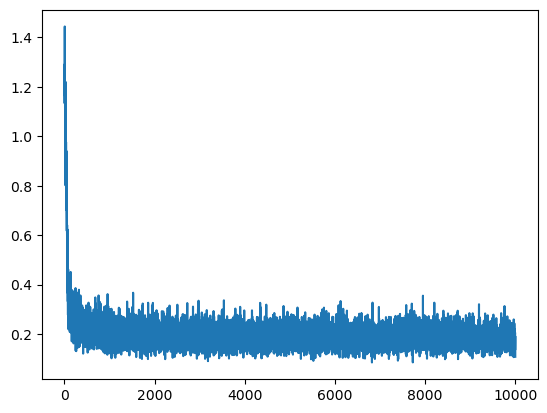

In [10]:
plt.plot(losses)

## Sampling

### Same thing as Model and Training section

In [ ]:
torch.manual_seed(42)
model.eval().requires_grad_(False)

# Gives the shape (number of points) of the pole region data
full_combined_df = pd.concat([model_df, grouped_df.drop(columns=['HiggsM_interval'])], axis=1)
combined_df_pole = full_combined_df[~(mask1 | mask2)]
true_points = combined_df_pole.to_numpy()

# Sample across the full HiggsM range (tails + pole region)
# Ensures that the number of samples in the pole region matches the number of true points
num_samples_per_region = true_points.shape[0]
steps = 1000

# Build HiggsM samples (already normalized)
HiggsM_min = 0.0
HiggsM_max = 1.0
# Normalise the lower and upper bounds for the pole region using the same scaler as HiggsM
lower_bound_norm = scaler_HiggsM.transform([[lower_bound]])[0, 0]
upper_bound_norm = scaler_HiggsM.transform([[upper_bound]])[0, 0]
# Generate samples for tails and pole region
HiggsM_tail_low = np.linspace(HiggsM_min, lower_bound_norm, num_samples_per_region)
HiggsM_pole = np.linspace(lower_bound_norm, upper_bound_norm, num_samples_per_region)
HiggsM_tail_high = np.linspace(upper_bound_norm, HiggsM_max, num_samples_per_region)
HiggsM_sample = np.concatenate([HiggsM_tail_low, HiggsM_pole, HiggsM_tail_high])
HiggsM_sample_norm = HiggsM_sample

# Initialize noise on device (same feature dimension as training data)
xt = torch.randn(len(HiggsM_sample), features_array.shape[1], device=device)
cond = torch.Tensor(HiggsM_sample_norm[:, None]).to(device)

# Sampling process
plot_every = 100
for step, t in enumerate(torch.linspace(0, 1, steps), start=1):
    with torch.no_grad():
        pred = model(xt, t.expand(xt.size(0)).to(device), cond)
    xt = xt + (1 / steps) * pred
    if step % plot_every == 0:
        print(f"{int(step/plot_every)}00 steps done")
        xt_denorm = xt.detach().cpu().numpy()

model.train().requires_grad_(True)
print("Done")

/tmp/ipykernel_81271/1992913580.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  true_pole_df = trimmed_df[~(mask1 | mask2)]


100 steps done
200 steps done
300 steps done
400 steps done
500 steps done
600 steps done
700 steps done
800 steps done
900 steps done
1000 steps done
Done


: 

### Taking output data and comparing it to true data by saving both as a csv file

In [33]:
# Denormalising the values produced by the model
HiggsM_denorm = scaler_HiggsM.inverse_transform(HiggsM_sample_norm.reshape(-1, 1)).flatten()
features_denorm = scaler_features.inverse_transform(xt.detach().cpu().numpy())

pred_points = pd.DataFrame({'HiggsM': HiggsM_denorm,
                            'DNN_score': features_denorm[:, 0],
                            'Frequency': features_denorm[:, 1],
                            'DPhi_jj': features_denorm[:, 2],
                            'Eta_jj': features_denorm[:, 3], 
                            'M_jj': features_denorm[:, 4],
                            'Njets': features_denorm[:, 5],
                            'OO1': features_denorm[:, 6],
                            })

# Constructing the pole region data for both the predicted and true data
model_df_pole = model_df[~(mask1 | mask2)]
others_df_pole = grouped_df[~(mask3 | mask4)]
model_df_pole.index.name = others_df_pole.index.name
true_points_pole = pd.concat([model_df_pole, others_df_pole.drop(columns=['HiggsM', 'HiggsM_interval'])], axis=1)
variables = ['HiggsM', 'DNN_score', 'Frequency', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1']
true_points_pole = true_points_pole[variables]
lower_bound = 115000
upper_bound = 135000
pred_points_pole = pred_points[(pred_points['HiggsM'] >= lower_bound) & (pred_points['HiggsM'] <= upper_bound)]

# Saving data to csv for comparison
csv1 = pd.DataFrame(pred_points_pole, columns=['HiggsM', 'DNN_score', 'Frequency', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1'])
csv2 = pd.DataFrame(true_points_pole, columns=['HiggsM', 'DNN_score', 'Frequency', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1'])
csv1.to_csv('data_dump/multi_predicted_pole_region.csv', index=False)
csv2.to_csv('data_dump/multi_true_pole_region.csv', index=False)
print(pred_points_pole)

            HiggsM  DNN_score     Frequency   DPhi_jj    Eta_jj          M_jj  \
399  115000.000000  -1.505743  17631.681641  2.020087  3.572980  455932.21875   
400  115000.000000  -1.486484  16127.700195  2.000818  3.582000  462168.25000   
401  115050.125313  -1.517718  17327.394531  2.011014  3.575664  459777.59375   
402  115100.250627  -1.494844  18352.759766  2.036376  3.565039  456327.65625   
403  115150.375940  -1.508628  17855.925781  2.020062  3.580077  458069.84375   
..             ...        ...           ...       ...       ...           ...   
796  134849.624060  -1.599994  12317.227539  1.997157  3.565146  470193.00000   
797  134899.749373  -1.597470  12474.615234  1.985681  3.565880  461238.56250   
798  134949.874687  -1.628033  10788.233398  1.998583  3.549368  465479.50000   
799  135000.000000  -1.615303  11513.825195  1.995810  3.583135  471321.15625   
800  135000.000000  -1.664025  11617.057617  1.995771  3.536028  471525.15625   

        Njets       OO1  
3

## KL Divergence calculation to assess quality of the model


In [44]:
# Convert true_points_pole and pred_points_pole to a numpy array
pred_points_array = pred_points_pole.to_numpy()
true_points_array = true_points_pole.to_numpy()
print(true_points_array.shape, pred_points_array.shape)

# Ensuring that both arrays have the same shape for KL Divergence calculation by trimming both ends
counter = 0
if pred_points_array.shape > true_points_array.shape:
    while pred_points_array.shape != true_points_array.shape:
        if counter % 2 == 0: 
            pred_points_array = np.delete(pred_points_array, -1, axis=0)
            counter += 1
        else:
            pred_points_array = np.delete(pred_points_array, 0, axis=0)
        counter += 1

elif pred_points_array.shape < true_points_array.shape:
    while pred_points_array.shape != true_points_array.shape:
        if counter % 2 == 0: 
            true_points_array = np.delete(true_points_array, -1, axis=0)
            counter += 1
        else:
            true_points_array = np.delete(true_points_array, 0, axis=0)
            counter += 1

# Implement KL Divergence calculation
for i in range(len(features)):
    true_sum = np.sum(true_points_array[:, i])
    p = np.array(true_points_array[:, i]) / true_sum
    pred_sum = np.sum(pred_points_array[:, i])
    q = np.array(pred_points_array[:, i]) / pred_sum

    epsilon = 1e-10
    p_smooth = p + epsilon
    q_smooth = q + epsilon

    kl_divergence = np.sum(p_smooth * np.log(p_smooth / q_smooth))
    
    
    if np.isinf(kl_divergence) or np.isnan(kl_divergence):
        error_df = pd.DataFrame(p_smooth/q_smooth)
        error_df.to_csv('data_dump/check.csv', index=False)


    if i==3:
        error_df = pd.DataFrame(p_smooth/q_smooth)
        error_df.to_csv('data_dump/check1.csv', index=False)


    print(f"KL Divergence between true and predicted distributions in the pole region: {kl_divergence} for feature {features[i]}")






(400, 8) (402, 8)
KL Divergence between true and predicted distributions in the pole region: 9.022945566141522e-09 for feature DNN_score
KL Divergence between true and predicted distributions in the pole region: 0.00010432165799770818 for feature Frequency
KL Divergence between true and predicted distributions in the pole region: 0.001151711639212634 for feature DPhi_jj
KL Divergence between true and predicted distributions in the pole region: 1.6359545220164857e-05 for feature Eta_jj
KL Divergence between true and predicted distributions in the pole region: 1.1397851868240119e-05 for feature M_jj
KL Divergence between true and predicted distributions in the pole region: 8.14305128313417e-05 for feature Njets
KL Divergence between true and predicted distributions in the pole region: 1.930375380680501e-05 for feature OO1


## Comparison between predicted and true values in the pole region using histograms

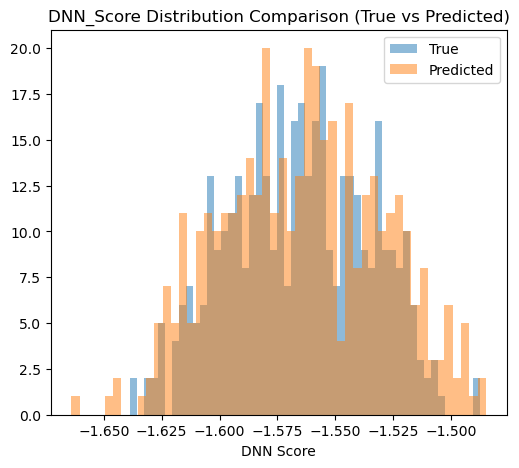

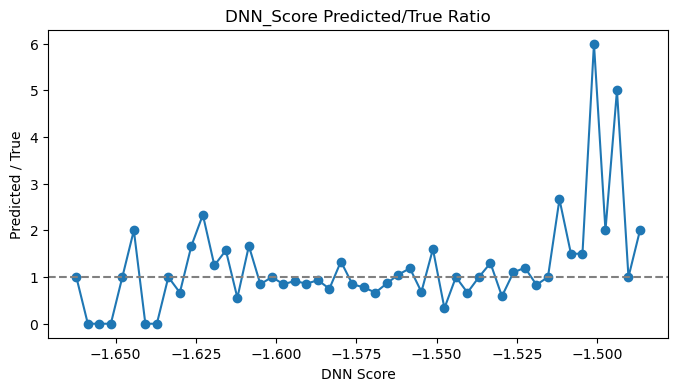

The average ratio across all bins for DNN_score is 1.21121102710499


In [72]:
# DNN_score distribution
DNN_true_df = np.sort(true_points_pole[['DNN_score']].to_numpy())
DNN_pred_df = np.sort(pred_points_pole[['DNN_score']].to_numpy())


# For plotting the ratios of the histograms
DNN_true_vals = DNN_true_df.ravel()
DNN_pred_vals = DNN_pred_df.ravel()
DNN_num_bins = 50
DNN_bin_edges = np.histogram_bin_edges(np.concatenate([DNN_true_vals, DNN_pred_vals]), bins=DNN_num_bins)
DNN_true_counts = np.histogram(DNN_true_vals, bins=DNN_bin_edges)[0]
DNN_pred_counts = np.histogram(DNN_pred_vals, bins=DNN_bin_edges)[0]
DNN_ratio = DNN_pred_counts / np.maximum(DNN_true_counts, 1) 
# Bin centers for plotting
DNN_bin_centers = 0.5 * (DNN_bin_edges[:-1] + DNN_bin_edges[1:])


plt.figure(1, figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(DNN_true_df, bins=DNN_num_bins, alpha=0.5, label='True')
plt.hist(DNN_pred_df, bins=DNN_num_bins, alpha=0.5, label='Predicted')
plt.xlabel('DNN Score')
plt.title('DNN_Score Distribution Comparison (True vs Predicted)')
plt.legend()
plt.savefig('graphs/DNN_score_comparison.png')

plt.figure(figsize=(8, 4))
plt.plot(DNN_bin_centers, DNN_ratio, marker='o')
plt.axhline(1.0, color='gray', linestyle='--')
plt.xlabel('DNN Score')
plt.ylabel('Predicted / True')
plt.title('DNN_Score Predicted/True Ratio')
plt.savefig('graphs/DNN_score_ratio.png')
plt.show()

print(f"The average ratio across all bins for DNN_score is {np.mean(DNN_ratio)}")

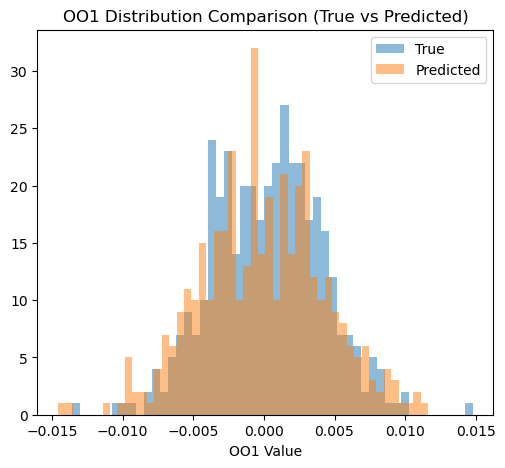

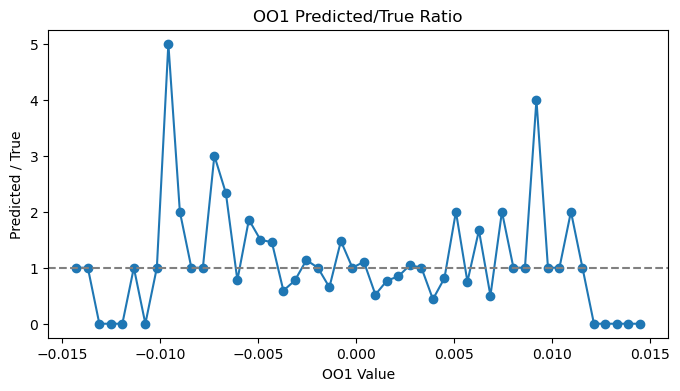

The average ratio across all bins for OO1 is 1.1000784677310995


In [73]:
# OO1 distribution
OO1_true_df = np.sort(true_points_pole[['OO1']].to_numpy())
OO1_pred_df = np.sort(pred_points_pole[['OO1']].to_numpy())

# For plotting the ratios of the histograms
OO1_true_vals = OO1_true_df.ravel()
OO1_pred_vals = OO1_pred_df.ravel()
OO1_num_bins = 50
OO1_bin_edges = np.histogram_bin_edges(np.concatenate([OO1_true_vals, OO1_pred_vals]), bins=OO1_num_bins)
OO1_true_counts = np.histogram(OO1_true_vals, bins=OO1_bin_edges)[0]
OO1_pred_counts = np.histogram(OO1_pred_vals, bins=OO1_bin_edges)[0]
OO1_ratio = OO1_pred_counts / np.maximum(OO1_true_counts, 1) 
# Bin centers for plotting
OO1_bin_centers = 0.5 * (OO1_bin_edges[:-1] + OO1_bin_edges[1:])


plt.figure(1, figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(OO1_true_df, bins=OO1_num_bins, alpha=0.5, label='True')
plt.hist(OO1_pred_df, bins=OO1_num_bins, alpha=0.5, label='Predicted')
plt.xlabel('OO1 Value')
plt.title('OO1 Distribution Comparison (True vs Predicted)')
plt.legend()
plt.savefig('graphs/OO1_comparison.png')

plt.figure(figsize=(8, 4))
plt.plot(OO1_bin_centers, OO1_ratio, marker='o')
plt.axhline(1.0, color='gray', linestyle='--')
plt.xlabel('OO1 Value')
plt.ylabel('Predicted / True')
plt.title('OO1 Predicted/True Ratio')
plt.savefig('graphs/OO1_ratio.png')
plt.show()


print(f"The average ratio across all bins for OO1 is {np.mean(OO1_ratio)}")

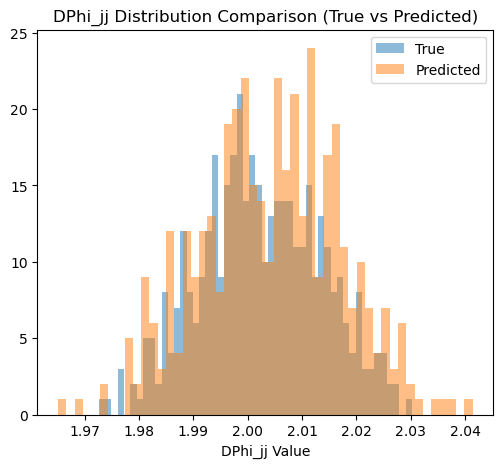

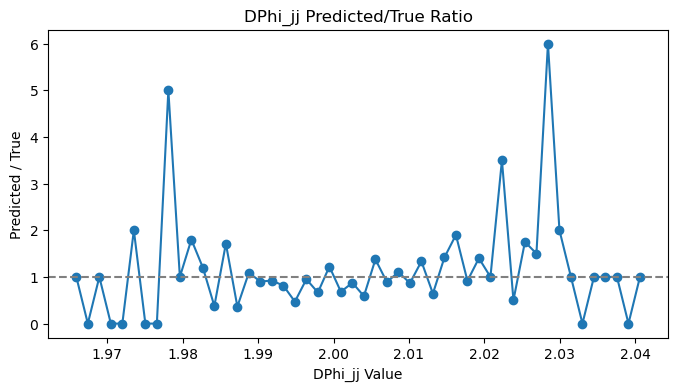

The average ratio across all bins for DPhi_jj is 1.1545856243000208


In [ ]:
# DPhi_jj distribution
DPhi_true_df = np.sort(true_points_pole[['DPhi_jj']].to_numpy())
DPhi_pred_df = np.sort(pred_points_pole[['DPhi_jj']].to_numpy())

# For plotting the ratios of the histograms
DPhi_true_vals = DPhi_true_df.ravel()
DPhi_pred_vals = DPhi_pred_df.ravel()
DPhi_num_bins = 50
DPhi_bin_edges = np.histogram_bin_edges(np.concatenate([DPhi_true_vals, DPhi_pred_vals]), bins=DPhi_num_bins)
DPhi_true_counts = np.histogram(DPhi_true_vals, bins=DPhi_bin_edges)[0]
DPhi_pred_counts = np.histogram(DPhi_pred_vals, bins=DPhi_bin_edges)[0]
DPhi_ratio = DPhi_pred_counts / np.maximum(DPhi_true_counts, 1) 
# Bin centers for plotting
DPhi_bin_centers = 0.5 * (DPhi_bin_edges[:-1] + DPhi_bin_edges[1:])


plt.figure(1, figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(DPhi_true_df, bins=DPhi_num_bins, alpha=0.5, label='True')
plt.hist(DPhi_pred_df, bins=DPhi_num_bins, alpha=0.5, label='Predicted')
plt.xlabel('DPhi_jj Value')
plt.title('DPhi_jj Distribution Comparison (True vs Predicted)')
plt.legend()
plt.savefig('graphs/DPhi_jj_comparison.png')

plt.figure(figsize=(8, 4))
plt.plot(DPhi_bin_centers, DPhi_ratio, marker='o')
plt.axhline(1.0, color='gray', linestyle='--')
plt.xlabel('DPhi_jj Value')
plt.ylabel('Predicted / True')
plt.title('DPhi_jj Predicted/True Ratio')
plt.savefig('graphs/DPhi_jj_ratio.png')
plt.show()

print(f"The average ratio across all bins for DPhi_jj is {np.mean(DPhi_ratio)}")